In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [5]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

In [66]:
def convert_to_cylindrical(coordinate,velocity,halo_center=[0.0,0.0,0.0],halo_vel=[0.0,0.0,0.0]):
    #convert a 3 element matrix into a matrix of spherical coordinates
    #I could calculate V_tan and then project it into the new xy plane

    #it also could just be cylindrical and just use V_theta
    #just do cylindrical

    #the basic formula for converting velocities from cartesian to cylindrical is
    #
    # v = (x*dx/dt+y*dy/dt)/r rhat + (x*dy/dt-y*dx/dt)/r thetahat + dz/dt zhat

    import numpy as np

    halo_center = np.asarray(halo_center)
    halo_vel = np.asarray(halo_vel)

    X = np.asarray(coordinate[:,0])-halo_center[0]
    Y = np.asarray(coordinate[:,1])-halo_center[1]
    Z = np.asarray(coordinate[:,2])-halo_center[2]

    VX = np.asarray(velocity[:,0])-halo_vel[0]
    VY = np.asarray(velocity[:,1])-halo_vel[1]
    VZ = np.asarray(velocity[:,2])-halo_vel[2]

    R = np.sqrt(X**2.0+Y**2.0)
    theta = np.arctan2(Y,X)

    D_cylindrical = np.zeros((len(R),3))
    D_cylindrical[:,0] = R
    D_cylindrical[:,1] = theta
    D_cylindrical[:,2] = Z

    Vr = (X*VX+Y*VY)/R
    Vtheta = (X*VY-Y*VX)/R
    Vz = VZ

    V_cylindrical = np.zeros((len(Vr),3))
    V_cylindrical[:,0] = Vr
    V_cylindrical[:,1] = Vtheta
    V_cylindrical[:,2] = Vz

    return D_cylindrical, V_cylindrical

def Calc_average_L_shift(coordinates,masses,velocities):
    #For already shifted and cut cordinates
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance

    coord_mod = coordinates
    mass_mod = masses
    vel_mod = velocities

    coord_shift = coord_mod
    vel_shift = vel_mod

    rcrossv = np.cross(coord_shift,vel_shift)
    L_vec = [mass_mod[ii]*rcrossv[ii] for ii in range(len(rcrossv))]

    L_avg = np.mean(L_vec,axis=0)
    den = np.sqrt(L_avg[0]**2.0+L_avg[1]**2.0+L_avg[2]**2.0)
    return L_avg/den

def Rotate_to_z_axis(coordinates,velocities,rotation_axis):
    import numpy as np
    import h5py, re, os
    from math import log10
    from astropy.cosmology import FlatLambdaCDM
    from andrew_hydro_sim_modules.simple_tools import get_distance_vector, get_distance
    #Okay I want to take in a "z" axis, and then rotate the
    #coordinates so that that is the z axis
    #then calculate velocity vectors in that frame and
    #then decompose it into spherical coordinates IN THAT FRAME

    L = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0+rotation_axis[2]**2.0) #total length
    R = np.sqrt(rotation_axis[0]**2.0+rotation_axis[1]**2.0) #length in xy plane
    
    R1 = np.asarray([[rotation_axis[0]/R,rotation_axis[1]/R,0.0],[-rotation_axis[1]/R,rotation_axis[0],0.0],[0.0,0.0,1.0]]) #rotation about z axis to project into xz plane
    R2 = np.asarray([[rotation_axis[2]/L,0.0,-R/L],[0.0,1.0,0.0],[R/L,0.0,rotation_axis[2]/L]]) #rotation about y axis to make given axis the z axis

    #apply rotation to coordinates and velocities
    
    coord_rotate = np.asarray([R2.dot(R1.dot(xx)) for xx in coordinates])
    vel_rotate = np.asarray([R2.dot(R1.dot(xx)) for xx in velocities])

    return coord_rotate, vel_rotate

In [64]:
#The correlation program is busted for reason that I don't quite understand
#as far as I can tell it has to be one of 3 things
#
# 1) a problem with the input particles either stars or dm
# 2) a problem with the NN algorithms
# 3) a problem with the sorting algorithms
#
# 1 is easy to check I just need to load up the particle data and plot it to see if it
# looks okay:

#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo_train = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

h = 0.702

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

f_parts = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.hdf5')

f_stars = f_parts['PartType4']

star_coords = f_stars['Coordinates'][:]/h
star_vel = f_stars['Velocities'][:]
star_mass = f_stars['Masses'][:]*1.0e10/h

f_train = h5py.File('./DM_data_w_stars_training.hdf5')

f_train_dm = f_train['PartType1']
M_star_train = f_train_dm['Stellar_Masses'][:]
coords_train = f_train_dm['Coordinates'][:]



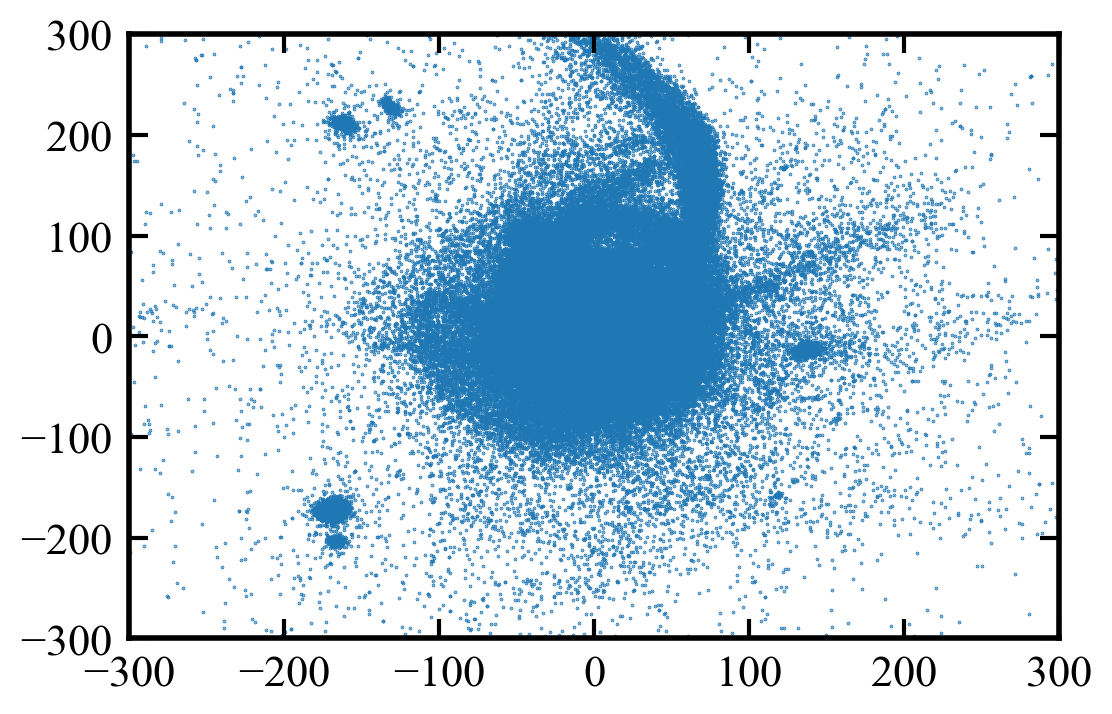

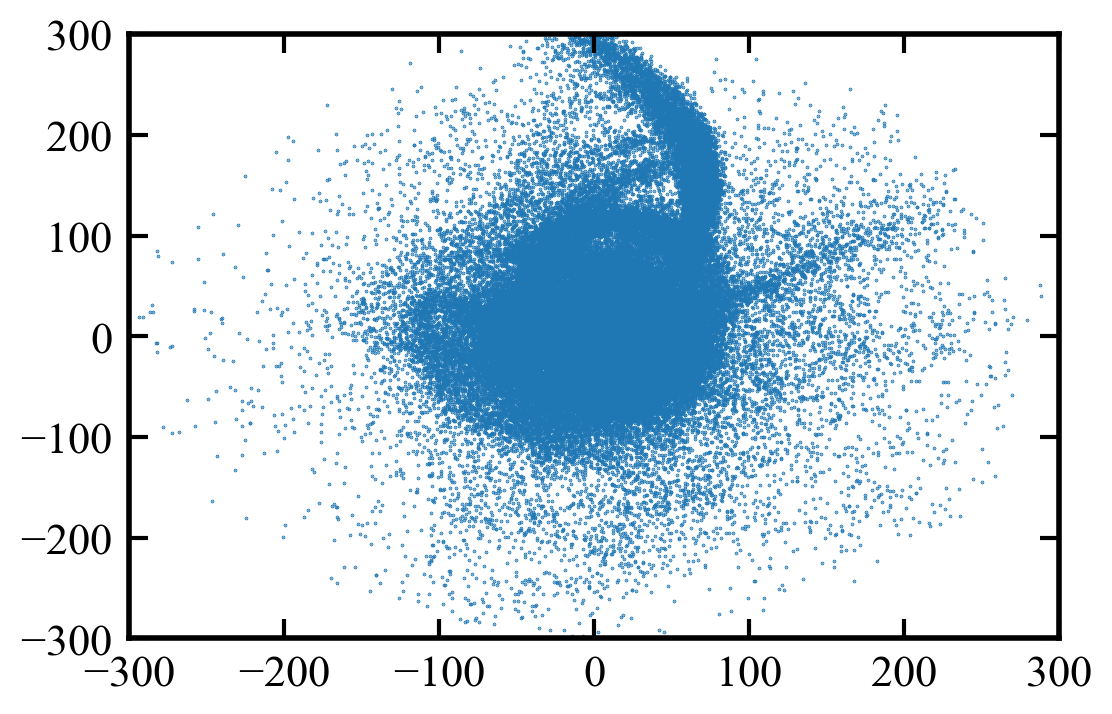

In [14]:
train_mask = (M_star_train>0.0)

plt.scatter(star_coords[:,0]-host_pos_train[0],star_coords[:,1]-host_pos_train[1],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(coords_train[:,0][train_mask]-host_pos_train[0],coords_train[:,1][train_mask]-host_pos_train[1],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

#plt.scatter(star_coords[:,1]-host_pos_train[1],star_coords[:,2]-host_pos_train[2],s=0.1)
#plt.xlim([-300.0,300.0])
#plt.ylim([-300.0,300.0])
#plt.show()
#
#plt.scatter(star_coords[:,2]-host_pos_train[2],star_coords[:,0]-host_pos_train[0],s=0.1)
#plt.xlim([-300.0,300.0])
#plt.ylim([-300.0,300.0])
#plt.show()

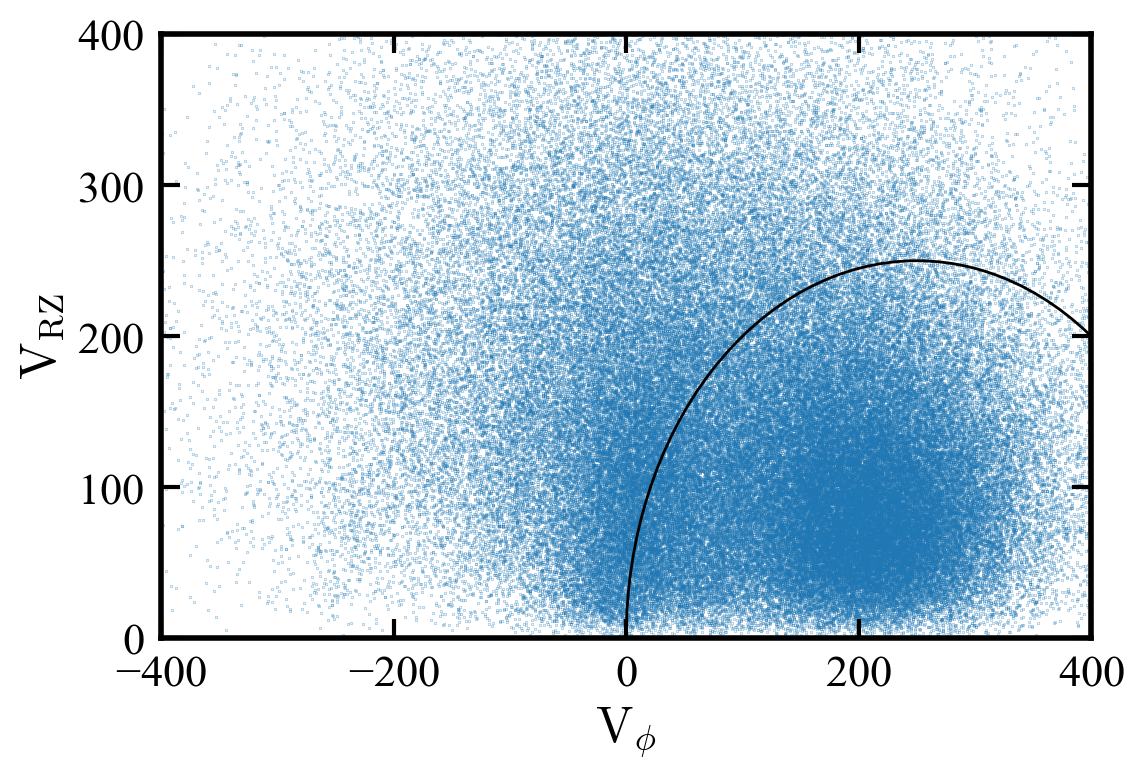

In [51]:
#I want to make a toomre diagram

d_cyl, v_cyl = convert_to_cylindrical(star_coords,star_vel,host_pos_train,host_vel_train)

Vrz = np.sqrt(v_cyl[:,0]**2.0+v_cyl[:,2]**2.0)
Vt = -1.0*v_cyl[:,1] #NOTE THERE'S A PHANTOM -1 here, could be a math error, or I could
                    #be doing something wrong, test by seeing if this eliminates the disk

circle1 = plt.Circle((250.0,0.0),250.0,edgecolor='k',fill=False)

fig, ax = plt.subplots()
ax.add_artist(circle1)
plt.scatter(Vt[::100],Vrz[::100],s=0.01)
plt.xlim([-400.0,400.0])
plt.ylim([0.0,400.0])
plt.xlabel(r'$\rm V_{\phi}$')
plt.ylabel(r'$\rm V_{RZ}$')
plt.show()

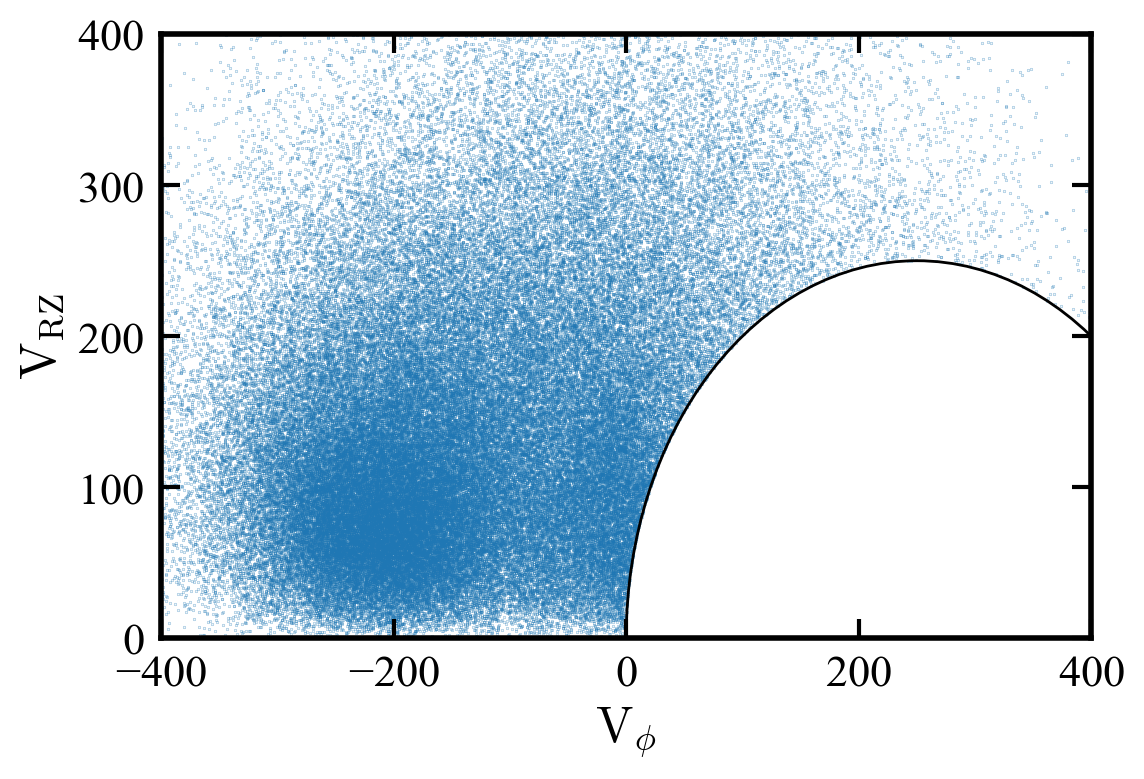

In [61]:
#remove everything from the circle

d_cyl, v_cyl = convert_to_cylindrical(star_coords,star_vel,host_pos_train,host_vel_train)

Vrz = np.sqrt(v_cyl[:,0]**2.0+v_cyl[:,2]**2.0)
Vt = v_cyl[:,1]

#to actually remove the points correctly I have to define a new velocity which is
#with respoect to the center of the removal circle

v_d = np.sqrt((Vt-250.0)**2.0+Vrz**2.0)
disk_mask = (v_d>250.0)


circle1 = plt.Circle((250.0,0.0),250.0,edgecolor='k',fill=False)

fig, ax = plt.subplots()
ax.add_artist(circle1)
plt.scatter(Vt[disk_mask][::100],Vrz[disk_mask][::100],s=0.01)
plt.xlim([-400.0,400.0])
plt.ylim([0.0,400.0])
plt.xlabel(r'$\rm V_{\phi}$')
plt.ylabel(r'$\rm V_{RZ}$')
plt.show()

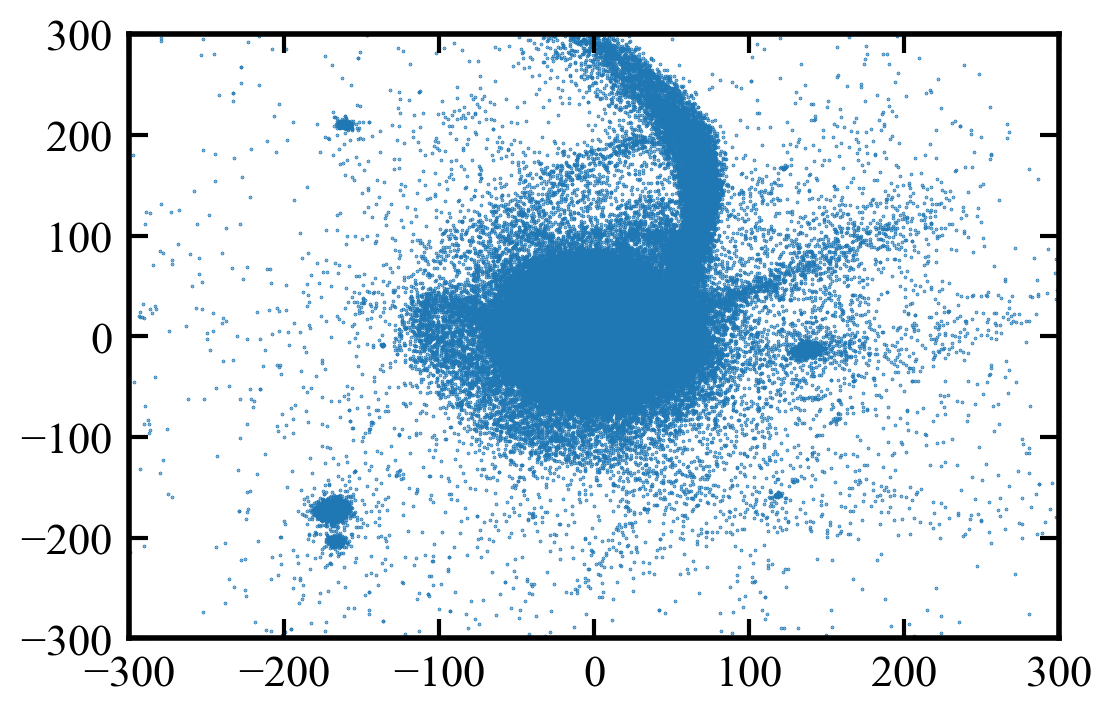

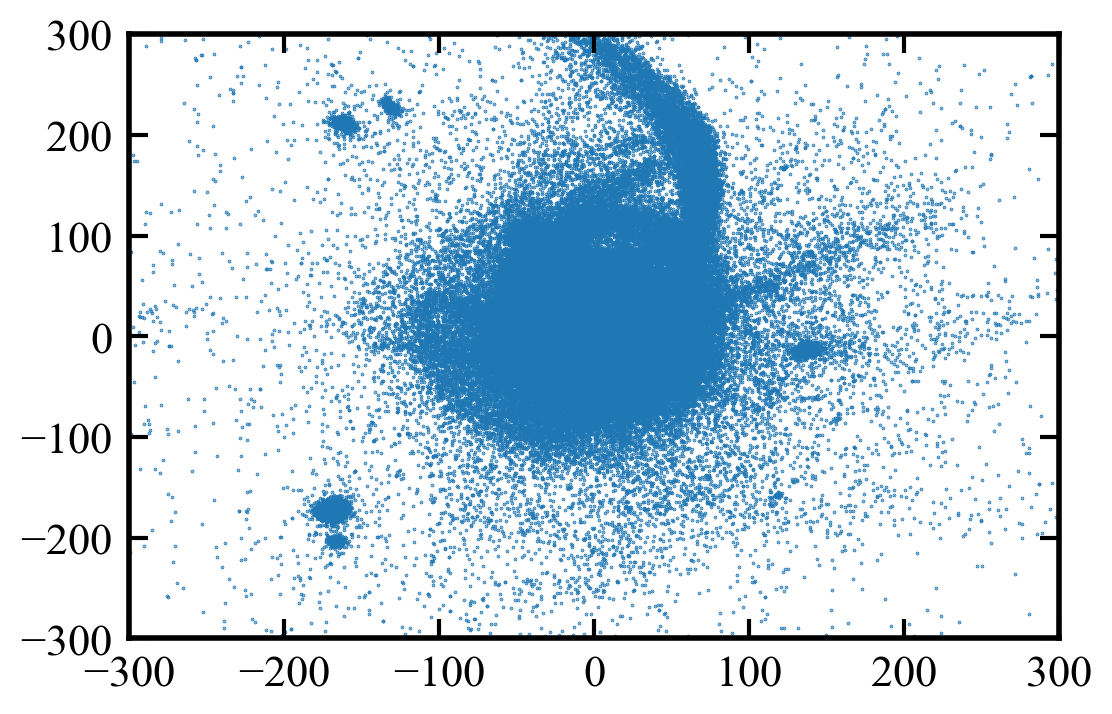

In [62]:
plt.scatter(star_coords[disk_mask][:,0]-host_pos_train[0],star_coords[disk_mask][:,1]-host_pos_train[1],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(star_coords[:,0]-host_pos_train[0],star_coords[:,1]-host_pos_train[1],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

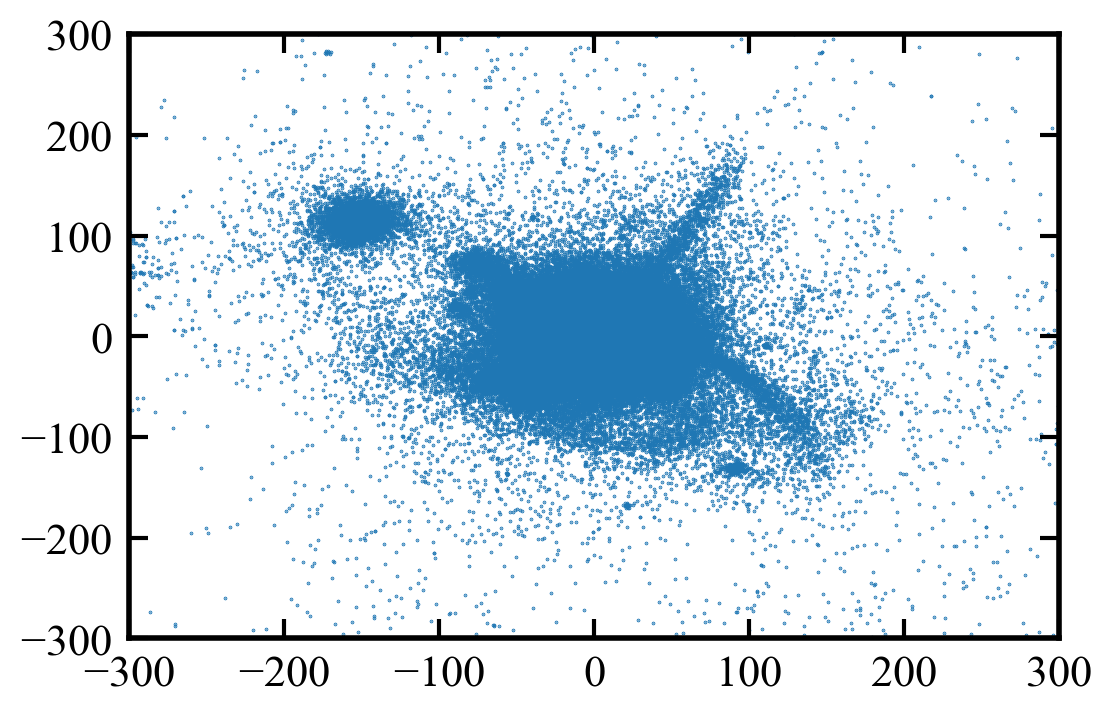

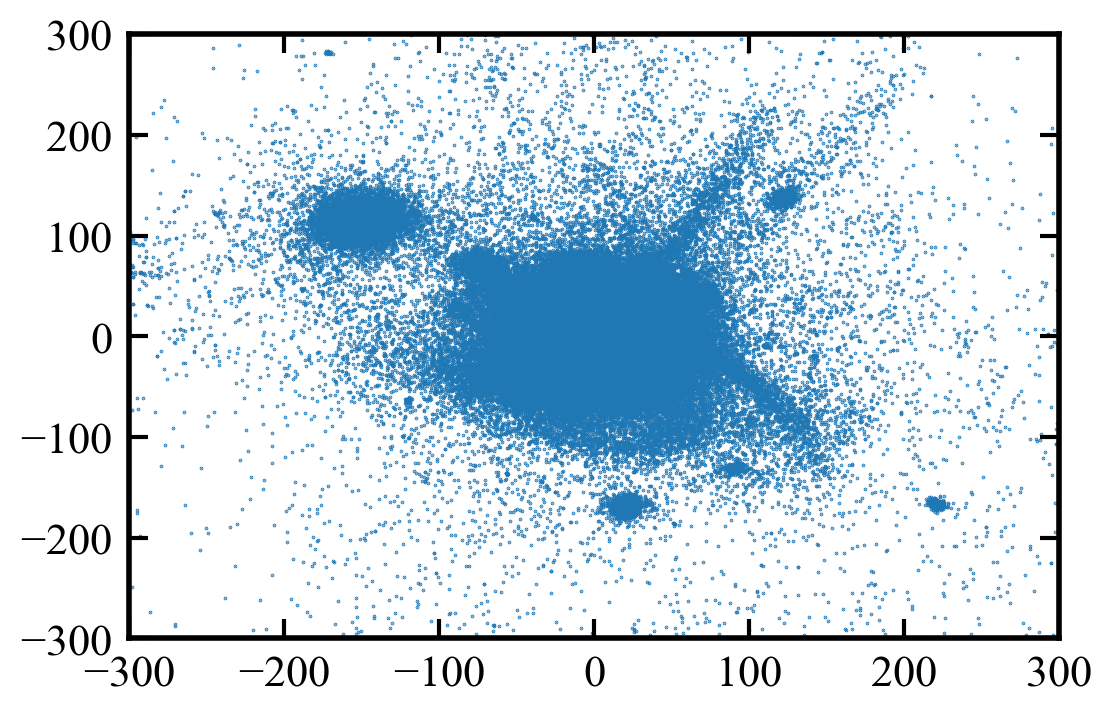

In [60]:
plt.scatter(star_coords[disk_mask][:,2]-host_pos_train[2],star_coords[disk_mask][:,0]-host_pos_train[0],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(star_coords[:,2]-host_pos_train[2],star_coords[:,0]-host_pos_train[0],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

In [65]:
coord_diff = star_coords-host_pos_train
vel_diff = star_vel-host_vel_train

L_vec =  Calc_average_L_shift(coord_diff,star_mass,vel_diff)

print L_vec

[ 0.85041899 -0.08385842 -0.51937973]


In [67]:
part_rotate, vel_rotate =  Rotate_to_z_axis(coord_diff,vel_diff,L_vec)

coord_cyl_disk, vel_cyl_disk = convert_to_cylindrical(part_rotate,vel_rotate)

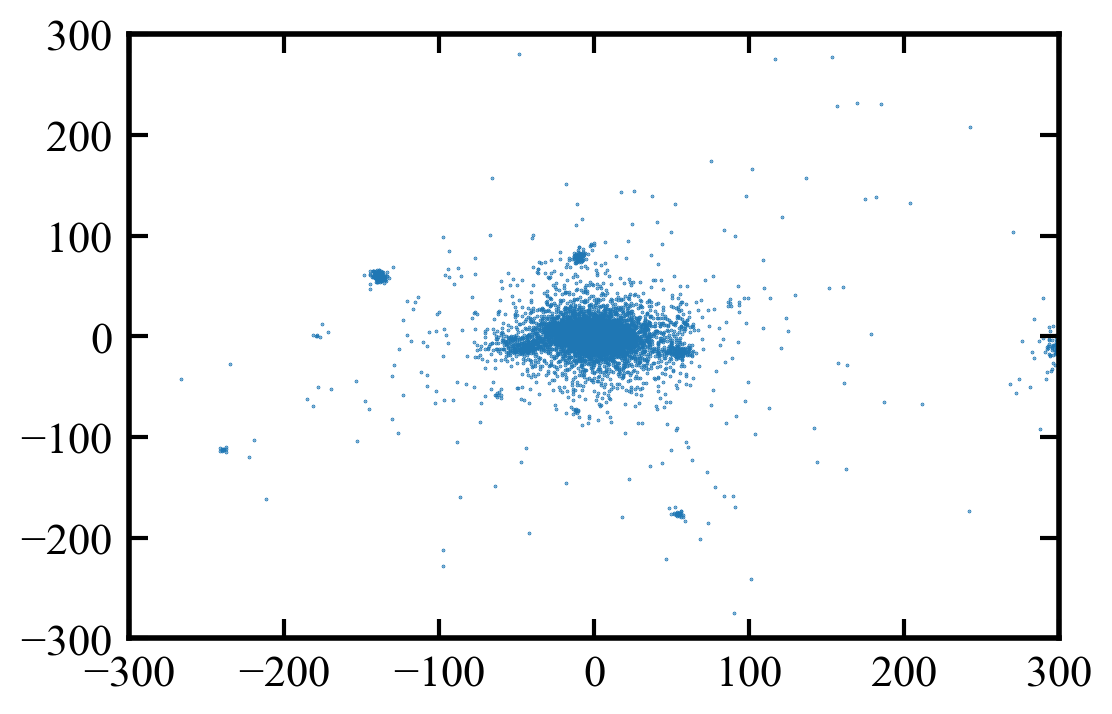

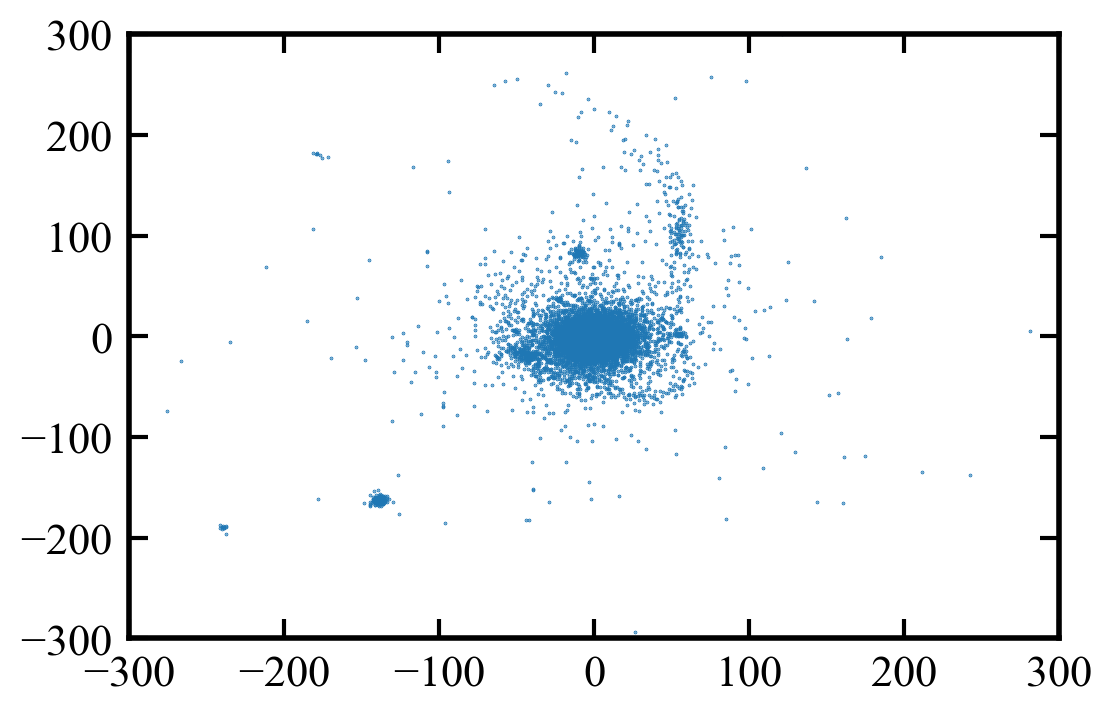

In [74]:
plt.scatter(part_rotate[:,2][::100],part_rotate[:,0][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(part_rotate[:,2][::100],part_rotate[:,1][::100],s=0.1)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()


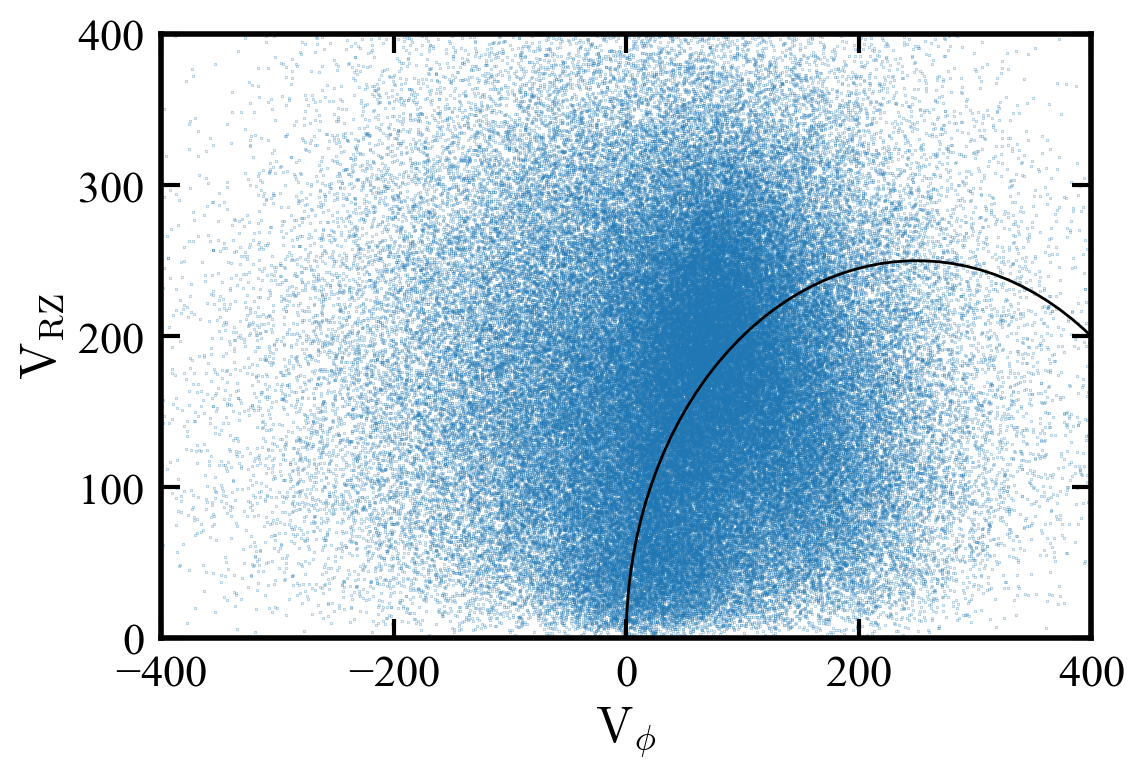

In [77]:
#make Toomre diagram with rotated points

Vrz = np.sqrt(vel_cyl_disk[:,0]**2.0+vel_cyl_disk[:,2]**2.0)
Vt = vel_cyl_disk[:,1]

#to actually remove the points correctly I have to define a new velocity which is
#with respoect to the center of the removal circle

v_d = np.sqrt((Vt-250.0)**2.0+Vrz**2.0)
disk_mask = (v_d>250.0)


circle1 = plt.Circle((250.0,0.0),250.0,edgecolor='k',fill=False)

fig, ax = plt.subplots()
ax.add_artist(circle1)
#plt.scatter(Vt[disk_mask][::100],Vrz[disk_mask][::100],s=0.01)
#plt.scatter(Vt[~disk_mask][::100],Vrz[~disk_mask][::100],s=0.01,color='k')

plt.scatter(Vt[::100],Vrz[::100],s=0.01)

plt.xlim([-400.0,400.0])
plt.ylim([0.0,400.0])
plt.xlabel(r'$\rm V_{\phi}$')
plt.ylabel(r'$\rm V_{RZ}$')
plt.show()

In [ ]:
#Hmmmmm this seems to not be working correctly. the coordinates are rotated, but they don't
#seem to be focused on the disk, potential issues
#
# 1) the random satellite galaxies greatly throw off the calculation
#        - remove all stars outside of 20 kpc?
# 2) the calculation has a flaw in it somewhere (potentially the calculation of L)
#        - calculate L for random vectors along unit sphere and compare